# Covid-19 Detection Using Deep Learning


### Dataset Descripion

The dataset used for this study is a combination of the below mentioned datasets from which the **`NORMAL`** and the **`COVID-19 INFECTED`** chest x-ray images have been extracted.

#### Constituent Datasets
1. https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset
2. https://github.com/ieee8023/covid-chestxray-dataset
3. https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [26]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GaussianNoise, GaussianDropout
from tensorflow.keras.layers import Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as img

from concurrent import futures
import threading
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import math
from collections import Counter

from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef

### Utilities and Functions

In [24]:
def ReadAndDisplayInputImages(imgList, numImagesToDisplay):
        
    '''
    Purpose: 
        Read and display the first 5 images of the imageCategory (Parasitized/Uninfected) 
        in the dataset.

    Parameters:
        1. imgList - The image list.
        2. numImagesToDisplay - Total number of images to display.

    Return Value: 
        NONE
    '''

    plt.figure(figsize=(20,10))
    columns = numImagesToDisplay
    
    # Read & display the images...
    for idx in range(0, numImagesToDisplay):
        plt.subplot(numImagesToDisplay / columns + 1, columns, idx + 1)
        plt.imshow(img.imread(imgList[idx]))
        plt.axis('off')
        
def ResizeAllImages(imageList, newImageSize):
        
    '''
    Purpose: 
        Resizes all the images passed in to the new dimension defined in 'newImageSize'. 
        As the number of images are large, this method utilizes parallel processing using the 
        ThreadPoolExecutor for faster computation.

    Parameters:
        1. imageList - The list of all the images that are to be re-sized.
        2. newImageSize - The size to which the images have to be re-sized.

    Return Value: 
        List of the resized images.
    '''

    '''A nested function to resize the image to the specified new dimension 
    and is called parallely from the ThreadPoolExecutor.
    Parameter:
        img - The image that is to be resized.'''
    def ResizeImage(img):
        try:
            img1 = cv2.imread(img)
            img1 = cv2.resize(img1, dsize=newImageSize, interpolation=cv2.INTER_CUBIC)
            img1 = np.array(img1, dtype=np.float32)
        except:
            pass
        return img1
    
    # https://docs.python.org/3/library/concurrent.futures.html for details on max_workers
    executer = futures.ThreadPoolExecutor(max_workers=None)
    try:
        train_data_map = executer.map(ResizeImage, [image for image in imageList])
    except:
        pass
    
    return np.array(list(train_data_map))


# Custom Function to get Scores and plots...
def Generate_Model_Test_Classification_Report(y_test, y_pred, model_name=""):

    '''
    Purpose: 
        Generate the consolidated test classification report. 
        The report consists of the following classification results & metrics -
            1. Confusion Matrix
            2. Classification Report
            3. F1 Score
            4. Accuracy
            5. Mathews Correlation Coefficient (MCC)
            6. Precision
            7. Recall
            8. AUROC Score - Area Under the Receiver Operating Characteristic Curve
            9. AUC-PR Score - Area Under the Precision Recall Curve.
            10. AUROC Curve - Area Under the Receiver Operating Characteristic Curve
            11. AUC-PR Curve - Area Under the Precision Recall Curve.

    Parameters:
        1. y_test - The Ground Truth for each test image.
        2. y_pred - The Predicted label for each image.
        3. model_name - Model Name

    Return Value: 
        NONE.
    '''

    # Report Title & Classification Mterics Abbreviations...
    fig, axes = plt.subplots(3, 1, figsize = (8, 3))
    axes[0].text(9, 1.8, "CONSOLIDATED MODEL TEST REPORT", fontsize=30, horizontalalignment='center', 
                 color='DarkBlue', weight = 'bold')

    axes[0].axis([0, 10, 0, 10])
    axes[0].axis('off')

    axes[1].text(9, 4, "Model Name: " + model_name, style='italic', 
                         fontsize=18, horizontalalignment='center', color='DarkOrange', weight = 'bold')

    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')

    axes[2].text(0, 4, "* 1 - Parasitized\t\t\t\t\t\t\t * 0 - Non Parasitized\n".expandtabs() +
                 "* MCC - Matthews Correlation Coefficient\t\t* AUC - Area Under The Curve\n".expandtabs() +
                 "* ROC - Receiver Operating Characteristics     " + 
                 "\t* AUROC - Area Under the Receiver Operating    Characteristics".expandtabs(), 
                 style='italic', fontsize=10, horizontalalignment='left', color='orangered')

    axes[2].axis([0, 10, 0, 10])
    axes[2].axis('off')

    scores = []
    metrics = ['F1       ', 'MCC      ', 'Precision', 'Recall   ', 'Accuracy ',
               'AUC_ROC  ', 'AUC_PR   ']

    # Plot ROC and PR curves using all models and test data...
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    precision, recall, th = precision_recall_curve(y_test, y_pred)

    # Calculate the individual classification metic scores...
    model_f1_score = f1_score(y_test, y_pred)
    model_matthews_corrcoef_score = matthews_corrcoef(y_test, y_pred)
    model_precision_score = precision_score(y_test, y_pred)
    model_recall_score = recall_score(y_test, y_pred)
    model_accuracy_score = accuracy_score(y_test, y_pred)
    model_auc_roc = auc(fpr, tpr)
    model_auc_pr = auc(recall, precision)

    scores.append([model_f1_score,
                   model_matthews_corrcoef_score,
                   model_precision_score,
                   model_recall_score,
                   model_accuracy_score,
                   model_auc_roc,
                   model_auc_pr])

    sampling_results = pd.DataFrame(columns = ['Classification Metric', 'Score Value'])
    for i in range(len(scores[0])):
        sampling_results.loc[i] = [metrics[i], scores[0][i]]

    sampling_results.index = np.arange(1, len(sampling_results) + 1)

    class_report = classification_report(y_test, y_pred)
    conf_matx = confusion_matrix(y_test, y_pred)

    # Display the Confusion Matrix...
    fig, axes = plt.subplots(1, 3, figsize = (20, 4))
    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 16},fmt='g', cbar=False, cmap="GnBu", ax=axes[0])
    axes[0].set_title("1. Confusion Matrix", fontsize=21, color='darkgreen', weight = 'bold', 
                      style='italic', loc='left', y=0.80)

    # Classification Metrics
    axes[1].text(5, 1.8, sampling_results.to_string(float_format='{:,.4f}'.format, index=False), style='italic', 
                 fontsize=20, horizontalalignment='center')
    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')
    axes[1].set_title("2. Classification Metrics", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center', y=0.80)

    # Classification Report
    axes[2].text(0, 1, class_report, style='italic', fontsize=20)
    axes[2].axis([0, 10, 0, 10])
    axes[2].axis('off')
    axes[2].set_title("3. Classification Report", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center', y=0.80)

    plt.tight_layout()
    plt.show()

    # AUC-ROC & Precision-Recall Curve
    fig, axes = plt.subplots(1, 2, figsize = (14, 4))

    axes[0].plot(fpr, tpr, label = f"auc_roc = {model_auc_roc:.3f}")
    axes[1].plot(recall, precision, label = f"auc_pr = {model_auc_pr:.3f}")

    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].legend(loc = "lower right")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("4. AUC - ROC Curve", fontsize=15, color='darkgreen', ha='right', weight = 'bold', 
                      style='italic', loc='center', pad=1, y=1.05)

    axes[1].legend(loc = "lower left")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("5. Precision - Recall Curve", fontsize=15, color='darkgreen', ha='right', weight = 'bold', 
                      style='italic', loc='center', pad=3, y=1.05)

    plt.subplots_adjust(top=0.95) 
    plt.tight_layout()
    plt.show()

### Data Preparation

In [3]:
# initialize the paths
Covid_Infected_Path = './Data/Covid-19/Infected/*.*'
Covid_Not_Infected_Path = './Data/Covid-19/Normal/*.*'

In [4]:
# get the list of images from both the category
covid_infected_images = glob.glob(Covid_Infected_Path)
covid_non_infected_images = glob.glob(Covid_Not_Infected_Path)


####  Covid Infected X-Ray Images

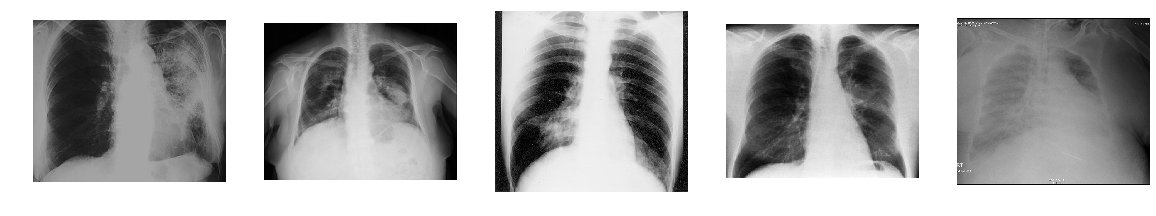

In [5]:
ReadAndDisplayInputImages(covid_infected_images, 5)

#### Normal X-Ray Images

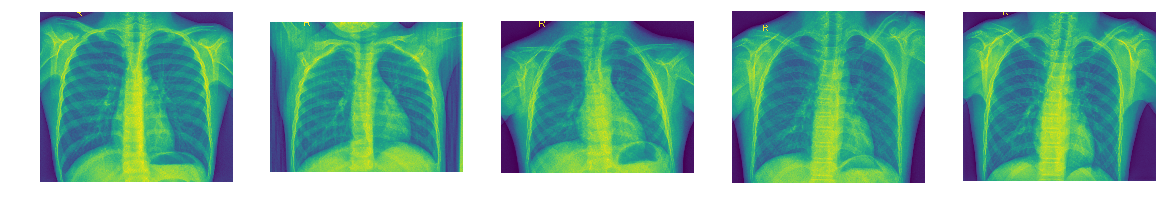

In [6]:
ReadAndDisplayInputImages(covid_non_infected_images, 5)

### Dataframe & Data Labelling

In [7]:
# create the dataframe
covid_df = pd.DataFrame({
    'filename': covid_infected_images + covid_non_infected_images,
    'label': ['Infected'] * len(covid_infected_images) + ['Normal'] * len(covid_non_infected_images)
})

# Shuffle the rows in the dataset
covid_df = covid_df.sample(frac=1, random_state=34).reset_index(drop=True)

covid_df.head()

,filename,label
0,./Data/Covid-19/Infected\person1473_virus_2551...,Infected
1,./Data/Covid-19/Infected\person1242_virus_2109...,Infected
2,./Data/Covid-19/Infected\person520_virus_1039....,Infected
3,./Data/Covid-19/Normal\IM-0505-0001-0001.jpeg,Normal
4,./Data/Covid-19/Normal\IM-0623-0001.jpeg,Normal


### Annotated Images

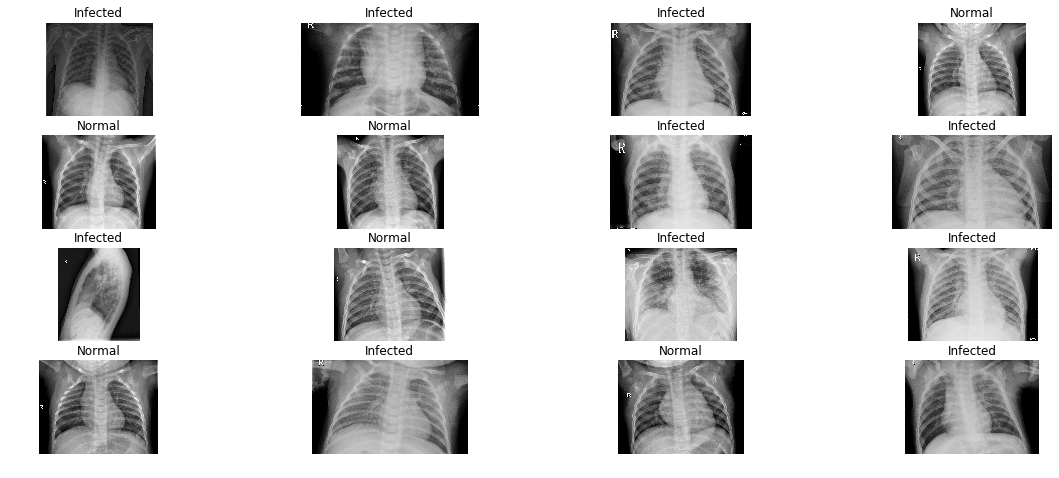

In [8]:
plt.figure(figsize=(20,10))
columns = 4
numImagesToDisplay = 16

# Read & display the images...
for idx in range(0, numImagesToDisplay):
    plt.subplot(numImagesToDisplay / columns + 1, columns, idx + 1)
    im = img.imread(covid_df.filename[idx])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.title(covid_df.label[idx])
    plt.axis('off')

### Test - Train - Validation Split

In [9]:
# train - test split
train_files, test_files, train_labels, test_labels = train_test_split(covid_df['filename'].values,
                                                                      covid_df['label'].values, 
                                                                      test_size=0.15, random_state=42)

# train - validation split
train_files, validation_files, train_labels, validation_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.10, random_state=42)

In [10]:
# Get the Tally of occurrences of the 2 labels in the generated datasets...

print('Training Data:', Counter(train_labels), 
      '\n\nValidation Data:', Counter(validation_labels), 
      '\n\nTest Data:', Counter(test_labels))

Training Data: Counter({'Infected': 1620, 'Normal': 1179}) 

Validation Data: Counter({'Infected': 186, 'Normal': 126}) 

Test Data: Counter({'Infected': 284, 'Normal': 266})


### Label Encoding

In [11]:
# Convert the labels into the binary formabt.
def EncodeLabels(covidLabels):
    encodedLabels = []
    for i in range(0, len(covidLabels)):
        if covidLabels[i] == 'Infected':
            encodedLabels.append(1)
        else:
            encodedLabels.append(0)
    return encodedLabels

y_train = EncodeLabels(train_labels)
y_validation = EncodeLabels(validation_labels)
y_test = EncodeLabels(test_labels)

print('Encoded Training Labels...\n')
print("Categorical Train Labels:", list(train_labels[:5]), 
      "\n\nEncoded Train Labels:    ", y_train[:5])

Encoded Training Labels...

Categorical Train Labels: ['Normal', 'Infected', 'Normal', 'Infected', 'Infected'] 

Encoded Train Labels:     [0, 1, 0, 1, 1]


### Image Resize

In [12]:
IMG_RESIZE_DIMS = (224, 224)

train_data = ResizeAllImages(train_files, IMG_RESIZE_DIMS)
validation_data = ResizeAllImages(validation_files, IMG_RESIZE_DIMS)
test_data = ResizeAllImages(test_files, IMG_RESIZE_DIMS)

#### Model Training Parameters

In [13]:
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 30
INPUT_SHAPE = (224, 224, 3)

### Data Augmentation

In [14]:
# create the data augmentors
train_data_augmentor = ImageDataGenerator(rescale=1./255, 
                                          rotation_range=20,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode="nearest")

validation_data_augmentor = ImageDataGenerator(rescale=1./255)

# create the image generators that would yield the 
# images on-the-fly during model training phase...
train_gen = train_data_augmentor.flow(train_data, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_gen = validation_data_augmentor.flow(validation_data, y_validation, batch_size=BATCH_SIZE, shuffle=False)

### Model Creation and Training

In [15]:
def BuildCustomModelWith(INPUT_SHAPE=(224, 224, 3)):

    model = Sequential(name = 'Custom_Covid-19')

    model.add(Conv2D(32, (3,3), padding='same',input_shape = INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print(model.summary())
    return model

In [16]:
model = BuildCustomModelWith()

Model: "Custom_Covid-19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 74, 74, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)    

### Model Checkpoints

In [17]:
filepath = './' + model.name + '.h5'
print("Model Checkpoint (.h5 file) Path:", filepath)

Model_Check_Point = ModelCheckpoint(filepath, 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             save_weights_only = False, 
                             mode = 'auto', 
                             save_freq = 'epoch')

Learning_Rate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, cooldown = 1, verbose = 1)
Early_Stop = EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1, mode = 'auto')

callback_list = [Model_Check_Point, Learning_Rate]

Model Checkpoint (.h5 file) Path: ./Custom_Covid-19.h5


### Train the Model - Model Fit

In [18]:
train_history = model.fit(train_gen,
                          steps_per_epoch=len(train_data) // BATCH_SIZE, 
                          epochs=EPOCHS,
                          validation_data=val_gen, 
                          validation_steps=len(validation_data) // BATCH_SIZE,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/30
87/87 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.6257
Epoch 00001: val_loss improved from inf to 0.54667, saving model to ./Custom_Covid-19.h5
87/87 [==============================] - 108s 1s/step - loss: 0.6532 - accuracy: 0.6257 - val_loss: 0.5467 - val_accuracy: 0.6910 - lr: 0.0010
Epoch 2/30
87/87 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.7882
Epoch 00002: val_loss improved from 0.54667 to 0.37729, saving model to ./Custom_Covid-19.h5
87/87 [==============================] - 112s 1s/step - loss: 0.4706 - accuracy: 0.7882 - val_loss: 0.3773 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 3/30
87/87 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8392
Epoch 00003: val_loss improved from 0.37729 to 0.37024, saving model to ./Custom_Covid-19.h5
87/87 [==============================] - 108s 1s/step - loss: 0.3811 - accuracy: 0.8392 - val_loss: 0.3702 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 4/30
87/

87/87 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9407
Epoch 00026: val_loss did not improve from 0.14528

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
87/87 [==============================] - 114s 1s/step - loss: 0.1700 - accuracy: 0.9407 - val_loss: 0.1561 - val_accuracy: 0.9514 - lr: 3.1250e-05
Epoch 27/30
87/87 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9357
Epoch 00027: val_loss did not improve from 0.14528
87/87 [==============================] - 113s 1s/step - loss: 0.1707 - accuracy: 0.9357 - val_loss: 0.1562 - val_accuracy: 0.9514 - lr: 1.5625e-05
Epoch 28/30
87/87 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9382
Epoch 00028: val_loss did not improve from 0.14528

Epoch 00028: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
87/87 [==============================] - 116s 1s/step - loss: 0.1595 - accuracy: 0.9382 - val_loss: 0.1495 - val_accu

### Model Training History

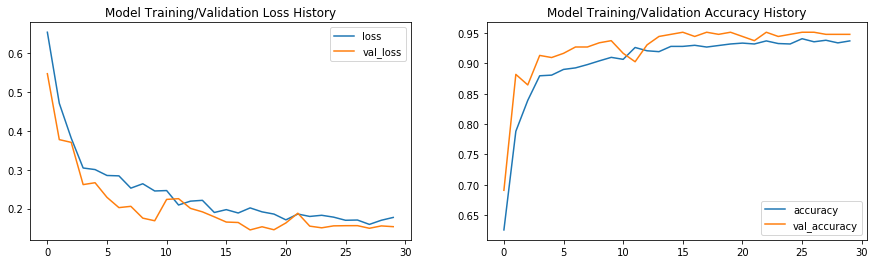

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(train_history.history['loss'])   
axes[0].plot(train_history.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[0].title.set_text("Model Training/Validation Loss History")

axes[1].plot(train_history.history['accuracy'])   
axes[1].plot(train_history.history['val_accuracy'])
axes[1].legend(['accuracy','val_accuracy'])
axes[1].title.set_text("Model Training/Validation Accuracy History")

### Model Testing

In [21]:
X_test = test_data / 255.

In [22]:
threshold = 0.50

y_preds_probability = model.predict(X_test)
y_preds_binary = [int(pred > threshold) for pred in y_preds_probability]

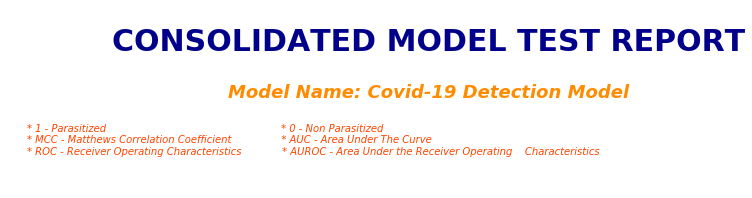

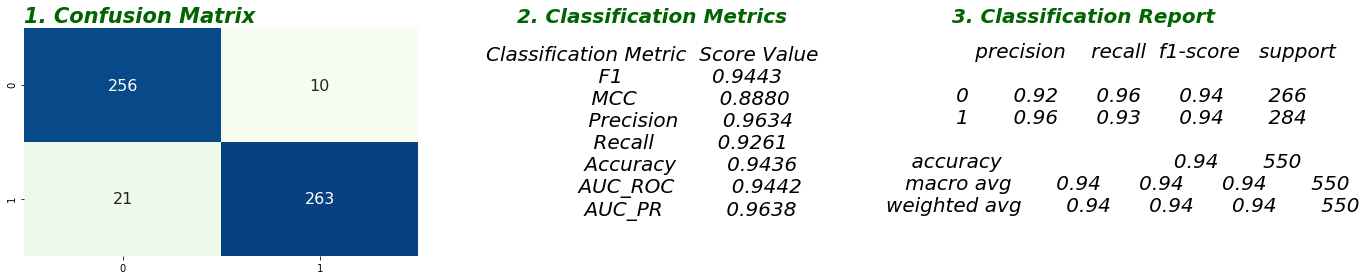

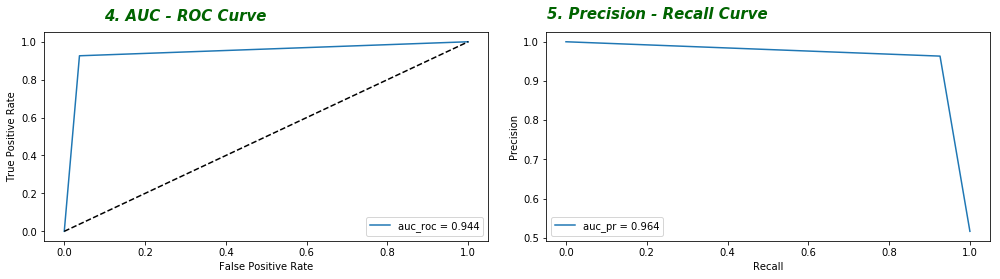

In [28]:
Generate_Model_Test_Classification_Report(y_test, y_preds_binary, 'Covid-19 Detection Model')